In [1]:
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATASET_PATH = "C:/code/kaggle/archive/fashion-dataset/fashion-dataset/"
print(os.listdir(DATASET_PATH))

['images', 'images.csv', 'preprocessedData', 'styles', 'styles.csv']


In [3]:
COMBINATION_JSON_PATH = "C:/code/kaggle/archive/fashion-dataset/combination.json"
# Open the JSON file
with open(COMBINATION_JSON_PATH) as file:
    # Load the JSON data
    data = json.load(file)

# Access the data
print(data)

{'Men': {'Spring': {'Casual': {'Bottomwear': [11346, 11294, 38576, 41349, 11289], 'Shoes': [54740, 3797, 26530, 39987, 50778], 'Topwear': [32769, 8315, 32768, 6998, 2160]}, 'Sports': {'Bottomwear': [32456, 32457, 9087, 30609, 4833], 'Shoes': [15747, 3307, 13215, 3300, 40322], 'Topwear': [8387, 2283, 32619, 1595, 32454]}, 'Formal': {'Bottomwear': [39808, 39806, 39807, 16391, 16390], 'Shoes': [57950, 12871, 12879, 12486, 12863], 'Topwear': [33246, 39801, 37808, 39798]}}}}


In [4]:
df = pd.read_csv(DATASET_PATH + "styles.csv")
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Unnamed: 10,Unnamed: 11,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,NaN,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,NaN,NaN,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,NaN,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,NaN,53759.jpg


In [5]:
len(df)

44440

In [6]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

## 以 Gender: Men, 
## Season: Spring, 
## Purpose: Casual, Sports, Formal,
## Part: Bottomwear, Shoes, Topwear
## 為例子

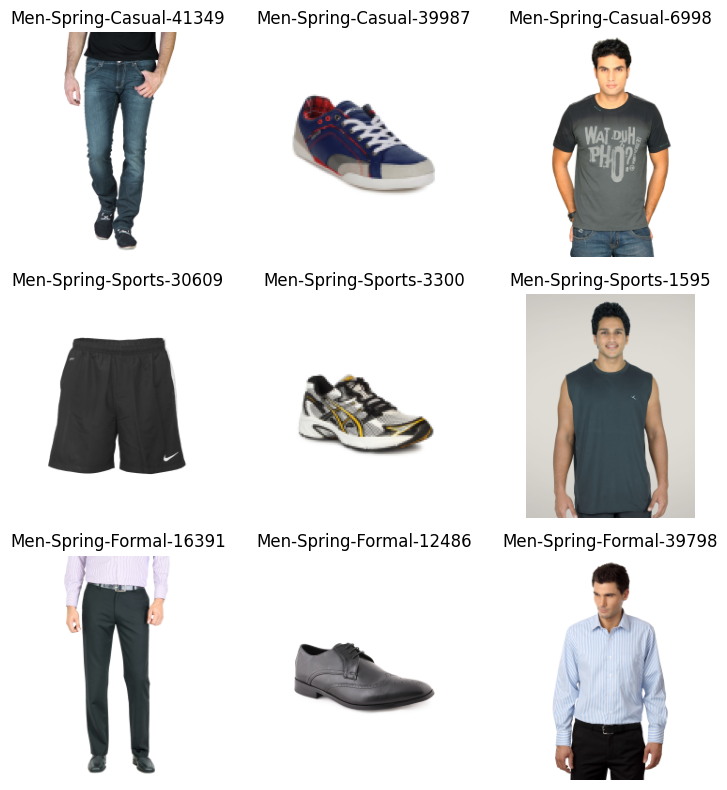

In [7]:
figures = {}
for gender, data2 in data.items():
#     print(gender)
    for season, data3 in data2.items():
#         print(season)
        for purpose, data4 in data3.items():
#             print(purpose)
            for part, imgList in data4.items():
#                 print(part)
                key = gender + "-" + season + "-" + purpose + '-' + str(imgList[3])
#                 print(str(imgList[0]) + ".jpg")
                value = load_image(str(imgList[3]) + ".jpg")
                
                figures[key] = value

# print(len(figures))
plot_figures(figures, 3, 3)

## Embedding vectors

In [8]:
import tensorflow as tf

In [9]:
# from tensorflow.keras import keras
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
import tensorflow.keras as keras
# import tensorflow.keras.applications.resnet50.preprocess_input as preprocess_input

In [10]:
# Input Shape
img_width, img_height, _ = 224, 224, 3

# Pre-Trained Model
base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
def get_embedding(model, img_name):
    # Reshape
    img = tf.keras.preprocessing.image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = tf.keras.preprocessing.image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x, verbose=0).reshape(-1)

In [12]:
df.iloc[0].image

'15970.jpg'

In [13]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

(2048,)

(240, 180, 3)
[ 5.9288645  2.3656547  0.        ...  1.3620473  0.        10.89064  ]


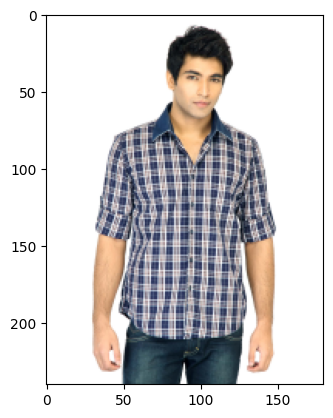

In [14]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [ ]:
print(len(df))

In [16]:
# from tqdm import tqdm 
# errorIndex = []
# for index in tqdm(range(len(df))):
#     try:
#         fileName = df.iloc[index].image
#         load_image(fileName)
#     except:
#         print(index)
#         errorIndex.append(index)

 15%|███████████▌                                                                 | 6701/44440 [02:22<12:55, 48.65it/s]

6695


 36%|███████████████████████████▋                                                | 16209/44440 [06:44<11:02, 42.60it/s]

16204


 73%|█████████████████████████████████████████████████████                    | 32325/44440 [16:31<27:20:01,  8.12s/it]

32320


 82%|████████████████████████████████████████████████████████████▌             | 36400/44440 [18:47<2:20:59,  1.05s/it]

36394


 90%|████████████████████████████████████████████████████████████████████▍       | 40026/44440 [20:30<01:36, 45.79it/s]

40016


100%|████████████████████████████████████████████████████████████████████████████| 44440/44440 [22:32<00:00, 32.86it/s]


In [15]:
dropList = [6695, 16204, 32320, 36394, 40016]
df = df.drop(dropList)

In [16]:
len(df)

44435

In [18]:
from tqdm import tqdm

In [19]:
embList = []
for index in tqdm(range(len(df))):
    emb = get_embedding(model, df.iloc[index].image)
    embList.append(emb)

100%|██████████████████████████████████████████████████████████████████████████| 44435/44435 [2:15:04<00:00,  5.48it/s]


In [20]:
df_embs = pd.DataFrame(embList)
df.to_csv('data.csv', index=False)
df_embs.to_csv('embedding.csv', index=False)

In [ ]:
# %%time
# import swifter

# # Parallel apply
# df_sample      = df#.sample(10)
# map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
# df_embs        = map_embeddings.apply(pd.Series)

# # print(df_embs.shape)
# df_embs.head()

In [ ]:
df_embs.head()

In [ ]:
len(df_embs)

In [ ]:
!ls

In [21]:
df.to_csv('data.csv', index=False)
df_embs.to_csv('embedding.csv', index=False)

## Predict Similar Clothes

In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.7127806 , 0.4536506 , 0.67929065],
       [0.7127806 , 1.        , 0.4152137 , 0.8332913 ],
       [0.4536506 , 0.4152137 , 1.        , 0.44625127],
       [0.67929065, 0.8332913 , 0.44625127, 0.9999998 ]], dtype=float32)

In [24]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Unnamed: 10,Unnamed: 11,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,NaN,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,NaN,NaN,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,NaN,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,NaN,53759.jpg


In [47]:
index = df[df['image'] == '1595.jpg'].index[0]
print(index)

35296


In [49]:
df.loc[index]

id                                                              1595
gender                                                           Men
masterCategory                                           Accessories
subCategory                                                  Watches
articleType                                                  Watches
baseColour                                                     Black
season                                                        Winter
year                                                          2016.0
usage                                                         Casual
productDisplayName    Fossil Men Black Dial Chronograph Watch CH2754
Unnamed: 10                                                      NaN
Unnamed: 11                                                      NaN
image                                                       1595.jpg
Name: 35296, dtype: object

In [39]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Unnamed: 10,Unnamed: 11,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,NaN,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,NaN,NaN,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,NaN,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,NaN,53759.jpg


In [56]:
indices = pd.Series(range(len(df)), index=df.index)


# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

recommend_clothes = get_recommender(35296, df, top_n = 5)


In [57]:
recommend_clothes

(Int64Index([10635, 13657, 41166, 44273, 3452], dtype='int64'),
 [0.885011, 0.8556913, 0.85097396, 0.8494544, 0.8334818])

In [58]:
recommend_clothes[0]

Int64Index([10635, 13657, 41166, 44273, 3452], dtype='int64')

38745.jpg
24354.jpg
57510.jpg
26785.jpg
2041.jpg


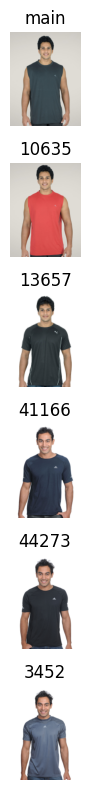

In [59]:
figures = {}
figures['main'] = load_image(df.loc[35296].image)

for ID in recommend_clothes[0]:
    print(df.iloc[ID].image)
    figures[str(ID)] = load_image(df.loc[ID].image)

# # print(len(figures))
plot_figures(figures, 6, 1)